# From classical to quantum repetition codes

In [61]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np


In [ ]:
def flip_bit(bit: str) -> str:
    return "1" if bit == "0" else "0"

def flip_bitstring(bitstring: str, probability: float) -> None:
    """Flip each bit of the given bitstring with the given probability."""
    flipped_bitstring: str = ""

    for bit in bitstring:
        if np.random.rand() < probability:
            flipped_bitstring += flip_bit(bit)
        else:
            flipped_bitstring += bit

    return flipped_bitstring

def majority_vote(bitstring: str) -> str:
    """Return the majority bit out of a given bitstring."""
    if len(bitstring)%2 == 0:
        print("Bitstring should have odd length for majority vote")
    ones_count: int = bitstring.count("1")
    zeros_count: int = bitstring.count("0")

    if ones_count > zeros_count:
        return "1"
    elif zeros_count > ones_count:
        return "0"
    return None

def error_sim_routine(bit: str, repeat_num: int = 3, probability: float = 0.3) -> str:
    """Run a full repetition error-correction routine."""
    repeated: str = bit * repeat_num
    after_error: str = flip_bitstring(repeated, probability)
    output_bit: str = majority_vote(after_error)

    return output_bit

def logical_error_rate(bit: str, repeat_num: int, probability: float, trials: int = 10_000) -> float:
    """Determine the logical error rate for a given probability, after a specified number of trials."""
    errors = 0
    for _ in range(trials):
        decoded: str = error_sim_routine(bit, repeat_num, probability)
        if decoded != bit:
            errors += 1
    return errors / trials

def logical_error_rate_theo(probability: float) -> float:
    """The logical error rate calculated analytically."""
    return 3*(probability**2) - 2*(probability**3)

In [ ]:
p_vals: np.ndarray = np.linspace(0, 0.99, 100)
rates: list[float] = [logical_error_rate("0", 3, p) for p in p_vals]
rates_ideal: list[float] = [logical_error_rate_theo(p) for p in p_vals]

findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont

findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Sans MS' not found.

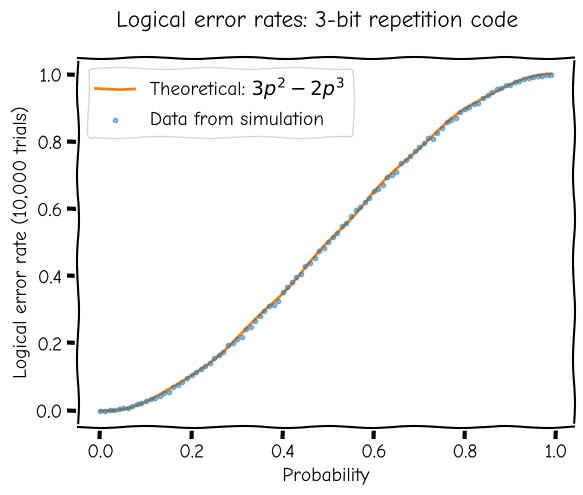

In [ ]:
cwd: Path = Path.cwd()
%matplotlib inline
with plt.xkcd():
    fig_test, ax_test = plt.subplots(1,1)

    ax_test.plot(p_vals, rates_ideal, color="C1", label=r"Theoretical: $3p^2 - 2p^3$", zorder=1)
    ax_test.scatter(p_vals, rates, alpha=0.5, s=10, label=r"Data from simulation")
    ax_test.set_ylabel("Logical error rate (10,000 trials)")
    ax_test.set_xlabel("Probability")

    ax_test.legend()
    # fig_test.show()
    fig_test.suptitle("Logical error rates: 3-bit repetition code")
    fig_test.savefig(cwd / "plots" / "classical_error_rates.png", dpi=300)

fig_test.show();